### Stage #1 - Building an LLM

- #### Step #1 - Data preparation and sampling

In [1]:
import os
import re

folder_name = 'llm-from-scratch'
file_name = 'the-verdict.txt'
print(f"{folder_name = }\n{file_name = }\n")

# Read the text/book.
with open(file=os.path.join(os.getcwd(), folder_name, file_name), mode='r', encoding='utf-8') as f:
    text_raw = f.read()

# Print the first 1000 characters of the text.
n_chars = 1000
print(f"Total number of characters in '{file_name}': {len(text_raw)}\n")
print(f"First {n_chars} characters of '{file_name}':\n\n{text_raw[:1000]}\n")

folder_name = 'llm-from-scratch'
file_name = 'the-verdict.txt'

Total number of characters in 'the-verdict.txt': 20479

First 1000 characters of 'the-verdict.txt':

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it's going to send the value of my picture 'way up; but I don't think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing's lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the l

__Difference between `pattern=r'(\s)'` and `pattern=r'\s+'` when used with `re.split`:__

__`pattern=r'\s+'`__
- __Meaning__: Matches one or more consecutive whitespace characters (spaces, tabs, newlines, etc.).
- __Behavior in__ `re.split`: Splits the string at every sequence of whitespace, and does not include the whitespace in the result.
- __Example__:
    ```python
    import re
    text = "Hello   world!\nHow are you?"
    print(re.split(r'\s+', text))
    # Output: ['Hello', 'world!', 'How', 'are', 'you?']
    ```

__`pattern=r'(\s)'`__
- __Meaning__: Matches a single whitespace character, and the parentheses create a capturing group.
- __Behavior in__ `re.split`: Splits the string at every single whitespace character, and includes the matched whitespace characters in the result as separate elements.
- __Example__:
    ```python
    import re
    text = "Hello   world!\nHow are you?"
    print(re.split(r'(\s)', text))
    # Output: ['Hello', ' ', '', ' ', '', ' ', 'world!', '\n', 'How', ' ', 'are', ' ', 'you?']
    ```

__Summary Table:__

| Pattern   | Splits on              | Includes whitespace in result? | Example Output                                      |
|-----------|------------------------|--------------------------------|-----------------------------------------------------|
| `r'\s+'`  | Any run of whitespace  | No                             | `['Hello', 'world!', 'How', 'are', 'you?']`         |
| `r'(\s)'` | Each whitespace char   | Yes (as separate elements)     | `['Hello', ' ', '', ' ', '', ' ', ...]`             |

__In short:__
- Use `r'\s+'` to split and discard whitespace.
- Use `r'(\s)'` to split and keep each whitespace character in the result.


In [2]:
# Create a sample of text.
n_chars = 1000
n_tokens = 40
text_sample = text_raw[:n_chars]
print(f"Sample of {n_chars} characters from '{file_name}':\n\n{text_sample}\n")

# Split at 'white-space' (\s) characters (excluding).
pattern = r'\s+'
# Split the text into tokens.
text_tokens = re.split(pattern=pattern, string=text_sample)
print(f"Pattern: r'{pattern}'")
print(f"Number of tokens in the sample: {len(text_tokens)}")
print(f"First {n_tokens} tokens in the sample:\n{text_tokens[:n_tokens]}\n") # Print the first 10 tokens.

# Split at 'white-space' character (including).
pattern = r'(\s)'
text_tokens = re.split(pattern=pattern, string=text_sample)
print(f"Pattern: r'{pattern}'")
print(f"Number of tokens in the sample: {len(text_tokens)}")
print(f"First {n_tokens} tokens in the sample:\n{text_tokens[:n_tokens]}\n")

# Split at 'white-space' characters (\s) and commas and period [,.] (excluding)
pattern = r'\s+|[,.]'
text_tokens = re.split(pattern=pattern, string=text_sample)
print(f"Pattern: r'{pattern}'")
print(f"Number of tokens in the sample: {len(text_tokens)}")
print(f"First {n_tokens} tokens in the sample:\n{text_tokens[:n_tokens]}\n")

# Split at 'white-space' character (\s) and commas and period [,.] (including).
pattern = r'(\s+|[,.])'
text_tokens = re.split(pattern=pattern, string=text_sample)
print(f"Pattern: r'{pattern}'")
print(f"Number of tokens in the sample: {len(text_tokens)}")
print(f"First {n_tokens} tokens in the sample:\n{text_tokens[:n_tokens]}\n")

Sample of 1000 characters from 'the-verdict.txt':

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it's going to send the value of my picture 'way up; but I don't think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing's lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn's "Moon-dancers" to say, with tears in her eyes: "We shall not

__`pattern = r'\s+|([,.:;?_!"()\'-]|--)'`__

When the above pattern is used, `None` values are generated in the split result because the regex pattern uses a capturing group.

When a capturing group is used in `re.split`, the matched text for the group is included in the result. If a split occurs on the part that matches `\s+` (whitespace), the capturing group does not match anything. Hence, `re.split` inserts `None` in the result for that split.

__How to Fix?__
After splitting, filter out `None` values from your token list.

```python
import re

text = "Hello   world! How are you? -- I'm fine."
pattern = r'\s+|([,.:;?_!\"()\'-]|--)'
tokens = re.split(pattern, text)
# Remove None and empty strings
tokens = [tok for tok in tokens if tok not in (None, '')]
print(tokens)
# Output: ['Hello', 'world', '!', 'How', 'are', 'you', '?', '--', "I'm", 'fine', '.']
```

In [3]:
# Split at 'white-space' character (\s) (exclude them) and other special characters, like commas, period, etc. (include them).
pattern = r'\s+|([,.:;?_!"()\'-]|--)'
text_tokens = re.split(pattern=pattern, string=text_raw)
print(f"Pattern: r'{pattern}'")
print(f"Number of tokens in the sample: {len(text_tokens)}")
print(f"First {n_tokens} tokens in the sample:\n{text_tokens[:n_tokens]}\n")

# Remove None and empty strings.
text_tokens = [token for token in text_tokens if token not in (None, '')]
print(f"Number of tokens in the sample (after cleaning): {len(text_tokens)}")
print(f"First {n_tokens} tokens in the sample (after cleaning):\n{text_tokens[:n_tokens]}\n")

Pattern: r'\s+|([,.:;?_!"()\'-]|--)'
Number of tokens in the sample: 9341
First 40 tokens in the sample:
['I', None, 'HAD', None, 'always', None, 'thought', None, 'Jack', None, 'Gisburn', None, 'rather', None, 'a', None, 'cheap', None, 'genius', '-', '', '-', 'though', None, 'a', None, 'good', None, 'fellow', None, 'enough', '-', '', '-', 'so', None, 'it', None, 'was', None]

Number of tokens in the sample (after cleaning): 4863
First 40 tokens in the sample (after cleaning):
['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '-', '-', 'though', 'a', 'good', 'fellow', 'enough', '-', '-', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in', 'the', 'height', 'of', 'his', 'glory', ',', 'he', 'had']



In [4]:
# Get unique tokens for the text.
n_token_ids = 20
unique_tokens = sorted(set(text_tokens))
print(f"Number of unique tokens in 'unique_tokens': {len(unique_tokens)}\n")
print(f"First {n_token_ids} unique tokens in 'unique_tokens':\n{unique_tokens[:n_token_ids]}\n")

# Create a dictionary of token ids.
vocab_token_ids = {
    token: token_id
    for token_id, token in enumerate(unique_tokens)
}
print(f"First {n_token_ids} items in 'vocab_token_ids':\n{list(vocab_token_ids.items())[:n_token_ids]}\n")

# Create a reverse dictionary of token ids.
reverse_vocab_token_ids = {
    token_id: token
    for token, token_id in vocab_token_ids.items()
}
print(f"First {n_token_ids} items in 'reverse_vocab_token_ids':\n{list(reverse_vocab_token_ids.items())[:n_token_ids]}")

Number of unique tokens in 'unique_tokens': 1139

First 20 unique tokens in 'unique_tokens':
['!', '"', "'", '(', ')', ',', '-', '.', ':', ';', '?', 'A', 'Ah', 'Among', 'And', 'Are', 'Arrt', 'As', 'At', 'Be']

First 20 items in 'vocab_token_ids':
[('!', 0), ('"', 1), ("'", 2), ('(', 3), (')', 4), (',', 5), ('-', 6), ('.', 7), (':', 8), (';', 9), ('?', 10), ('A', 11), ('Ah', 12), ('Among', 13), ('And', 14), ('Are', 15), ('Arrt', 16), ('As', 17), ('At', 18), ('Be', 19)]

First 20 items in 'reverse_vocab_token_ids':
[(0, '!'), (1, '"'), (2, "'"), (3, '('), (4, ')'), (5, ','), (6, '-'), (7, '.'), (8, ':'), (9, ';'), (10, '?'), (11, 'A'), (12, 'Ah'), (13, 'Among'), (14, 'And'), (15, 'Are'), (16, 'Arrt'), (17, 'As'), (18, 'At'), (19, 'Be')]


Explanation for 
```python
text = re.sub(r'\s+([,.:;?_!"()\'-]|--)', r'\1', text)
```

- Pattern: `r'\s+([,.:;?_!"()\'-]|--)'`

    - `\s+` matches one or more whitespace characters (spaces, tabs, newlines, etc.).
    - `([,.:;?_!"()\'-]|--)` is a capturing group that matches any one of the listed punctuation marks or a double dash (--).

- Replacement: `r'\1'`
    - `\1` refers to the text matched by the capturing group (the punctuation).

- What it does:
    - __Finds__: Any whitespace that comes immediately before one of the listed punctuation marks.
    - __Replaces__: The whitespace and the punctuation with just the punctuation (removes the whitespace before punctuation).

- Example:
    ```python
    text = "Hello , world ! How are you ? -- I'm fine ."
    text = re.sub(r'\s+([,.:;?_!"()\'-]|--)', r'\1', text)
    print(text)
    # Hello, world! How are you?-- I'm fine.
    ```

- Summary:

    This line removes any whitespace that appears before punctuation, so punctuation is directly attached to the preceding word. This is useful for detokenizing text after splitting punctuation into separate tokens.

In [5]:
# Create a tokeniser class - version1.
class SimpleTokeniserV1:
    def __init__(self, vocab, pattern=r'\s+|([,.:;?_!"()\'-]|--)'):
        self.vocab = vocab
        self.reverse_vocab = {value: key for key, value in vocab.items()}
        self.pattern = pattern
    
    def encoder(self, text):
        tokens = re.split(pattern=self.pattern, string=text)
        tokens = [token for token in tokens if token not in (None, '')]

        token_ids = [self.vocab[token] for token in tokens]

        return token_ids
        
    def decoder(self, token_ids):
        text = ' '.join([self.reverse_vocab[token_id] for token_id in token_ids])
        # _tokens = [self.reverse_vocab[_token_id] for _token_id in token_ids]
        # _text = ' '.join(_tokens) # Join tokens with a space.
        
        # Remove white-space before special characters.
        text = re.sub(''.join(self.pattern.split('|', maxsplit=1)), r'\1', text)

        return text

In [6]:
# Test 'SimpleTokeniserV1' class.
# Create a sample of text.
text_sample = """
"My dear, since I've chucked painting people don't say that stuff about me--they say it about Victor Grindle," was his only protest, as he rose from the table and strolled out onto the sunlit terrace.
"""

# Create a tokeniser object.
tokeniser = SimpleTokeniserV1(vocab=vocab_token_ids)

# Encode the text.
text_encoded = tokeniser.encoder(text=text_sample)
print(f"Encoded text:\n{text_encoded}\n")

# Decode the text.
text_decoded = tokeniser.decoder(token_ids=text_encoded)
print(f"Decoded text:\n{text_decoded}")

Encoded text:
[1, 68, 325, 5, 903, 53, 2, 1071, 263, 752, 768, 365, 2, 979, 864, 996, 954, 118, 666, 6, 6, 1003, 864, 588, 118, 105, 42, 5, 1, 1087, 551, 735, 807, 5, 175, 535, 854, 483, 997, 980, 157, 949, 742, 736, 997, 965, 992, 7]

Decoded text:
" My dear, since I' ve chucked painting people don' t say that stuff about me-- they say it about Victor Grindle," was his only protest, as he rose from the table and strolled out onto the sunlit terrace.


In [7]:
n_token_ids = 10

# Create unique tokens and add tokens for unknown ('<|unk|>') and end-of-text (<|endoftext|>).
unique_tokens_all = sorted(set(text_tokens))
print(f"Number of unique tokens in 'unique_tokens_all': {len(unique_tokens_all)}\n")
unique_tokens_all.extend(['<|unk|>', '<|endoftext|>'])
print(f"Number of unique tokens in 'unique_tokens_all' afterwards: {len(unique_tokens_all)}\n")

# Create a dictionary of token ids.
vocab_token_ids_all = {
    token: token_id
    for token_id, token in enumerate(unique_tokens_all)
}
print(f"Last {n_token_ids} items in 'vocab_token_ids_all':\n{list(vocab_token_ids_all.items())[-n_token_ids:]}\n")

# Create a reverse dictionary of token ids.
reverse_vocab_token_ids_all = {
    token_id: token
    for token, token_id in vocab_token_ids_all.items()
}
print(f"Last {n_token_ids} items in 'reverse_vocab_token_ids_all':\n{list(reverse_vocab_token_ids_all.items())[-n_token_ids:]}")

Number of unique tokens in 'unique_tokens_all': 1139

Number of unique tokens in 'unique_tokens_all' afterwards: 1141

Last 10 items in 'vocab_token_ids_all':
[('year', 1131), ('years', 1132), ('yellow', 1133), ('yet', 1134), ('you', 1135), ('younger', 1136), ('your', 1137), ('yourself', 1138), ('<|unk|>', 1139), ('<|endoftext|>', 1140)]

Last 10 items in 'reverse_vocab_token_ids_all':
[(1131, 'year'), (1132, 'years'), (1133, 'yellow'), (1134, 'yet'), (1135, 'you'), (1136, 'younger'), (1137, 'your'), (1138, 'yourself'), (1139, '<|unk|>'), (1140, '<|endoftext|>')]


In [8]:
# Create updated tokeniser class - version2.
class SimpleTokeniserV2:
    def __init__(self, vocab, pattern=r'\s+|([,.:;?_!"()\'-]|--)'):
        self.vocab = vocab
        self.reverse_vocab = {value: key for key, value in vocab.items()}
        self.pattern = pattern
    
    def encoder(self, text):
        tokens = re.split(pattern=self.pattern, string=text)
        tokens = [token for token in tokens if token not in (None, '')]

        # Add unknown token for unknown tokens.
        tokens = [
            token if token in self.vocab else '<|unk|>' 
            for token in tokens
        ]
        token_ids = [self.vocab[token] for token in tokens]

        return token_ids
        
    def decoder(self, token_ids):
        text = ' '.join([self.reverse_vocab[token_id] for token_id in token_ids])
        
        # Remove white-space before special characters.
        text = re.sub(''.join(self.pattern.split('|', maxsplit=1)), r'\1', text)

        return text

In [9]:
# Test 'SimpleTokeniserV2' class.
# Create a sample of text.
text_01 = """Hello, world...!!!"""
text_02 = """Welcome to the world of LLMs."""

# Create 'end-of-text' token.
text_sample = ' <|endoftext|> '.join((text_01, text_02))
print(f"Text sample with 'end-of-text' token:\n{text_sample}\n")

# Create a tokeniser object.
tokeniser = SimpleTokeniserV2(vocab=vocab_token_ids_all)

# Encode the text.
text_encoded = tokeniser.encoder(text=text_sample)
print(f"Encoded text:\n{text_encoded}\n")

# Decode the text.
text_decoded = tokeniser.decoder(token_ids=text_encoded)
print(f"Decoded text:\n{text_decoded}")

Text sample with 'end-of-text' token:
Hello, world...!!! <|endoftext|> Welcome to the world of LLMs.

Encoded text:
[1139, 5, 1139, 7, 7, 7, 0, 0, 0, 1140, 1139, 1025, 997, 1139, 726, 1139, 7]

Decoded text:
<|unk|>, <|unk|>...!!! <|endoftext|> <|unk|> to the <|unk|> of <|unk|>.


Tokeniser - BPE (byte pair encoding).

In [10]:
# uv add tiktoken
import importlib
import tiktoken

print(f"{importlib.metadata.version('tiktoken') = }")

importlib.metadata.version('tiktoken') = '0.9.0'


```python
?tiktoken.get_encoding
# help(tiktoken.get_encoding)
```

```
Signature: tiktoken.get_encoding(encoding_name: 'str') -> 'Encoding'
Docstring: <no docstring>
File:      ~/Study/github/python-examples/llm-from-scratch/.venv/lib/python3.11/site-packages/tiktoken/registry.py
Type:      function
```

Example

In [11]:
# Create a tokeniser instance with 'tiktoken'.
tokeniser = tiktoken.get_encoding(encoding_name='gpt2')

In [12]:
# Define a sample text.
text_sample = """
Hello, world...!!! Welcome to the world of LLMs.
"""
# Encode the text.
text_encoded = tokeniser.encode(text=text_sample, allowed_special='all')
print(f"Encoded text with 'line-break':\n{text_encoded}\n")

text_sample = """
Hello, world...!!! <|endoftext|> Welcome to the world of LLMs <|endoftext|>.
"""
# Encode the text.
text_encoded = tokeniser.encode(text=text_sample, allowed_special='all')
print(f"Encoded text with 'line-break' and 'end-of-text':\n{text_encoded}\n")

text_sample = """Hello, world...!!! <|endoftext|> Welcome to the world of LLMs <|endoftext|>."""
# Encode the text.
text_encoded = tokeniser.encode(text=text_sample, allowed_special='all')
print(f"Encoded text without 'line-break' and with 'end-of-text':\n{text_encoded}")

Encoded text with 'line-break':
[198, 15496, 11, 995, 986, 10185, 19134, 284, 262, 995, 286, 27140, 10128, 13, 198]

Encoded text with 'line-break' and 'end-of-text':
[198, 15496, 11, 995, 986, 10185, 220, 50256, 19134, 284, 262, 995, 286, 27140, 10128, 220, 50256, 13, 198]

Encoded text without 'line-break' and with 'end-of-text':
[15496, 11, 995, 986, 10185, 220, 50256, 19134, 284, 262, 995, 286, 27140, 10128, 220, 50256, 13]


In [13]:
# Define a sample text.
text_sample = """
Hello, world...!!! <|endoftext|> Welcome to the world of LLMs.
"""

# Encode the text.
text_encoded = tokeniser.encode(text=text_sample, allowed_special='all')
print(f"Encoded text:\n{text_encoded}\n")

# Decode the text.
text_decoded = tokeniser.decode(tokens=text_encoded)
print(f"Decoded text:\n{text_decoded}")

Encoded text:
[198, 15496, 11, 995, 986, 10185, 220, 50256, 19134, 284, 262, 995, 286, 27140, 10128, 13, 198]

Decoded text:

Hello, world...!!! <|endoftext|> Welcome to the world of LLMs.



In [14]:
# Define random text.
text_sample = """
hsakhgkk 798796 ^%$jvja ":>>L)(*)
"""

# Encode the text.
text_encoded = tokeniser.encode(text=text_sample, allowed_special='all')
print(f"Encoded 'random' text:\n{text_encoded}\n")

# Decode the text.
text_decoded = tokeniser.decode(tokens=text_encoded)
print(f"Decoded 'random' text:\n{text_decoded}")

Encoded 'random' text:
[198, 11994, 11322, 70, 28747, 767, 4089, 41060, 10563, 4, 3, 73, 85, 6592, 366, 25, 4211, 43, 5769, 28104, 198]

Decoded 'random' text:

hsakhgkk 798796 ^%$jvja ":>>L)(*)



Create `input-target` pairs.

In [15]:
print(text_raw[:500])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it'


In [16]:
text_encoded = tokeniser.encode(text=text_raw, allowed_special='all')
print(f"Sample of encoded text:\n{text_encoded[:100]}\n")
print(f"Number of tokens in the text: {len(text_encoded)}\n")

print(f"{'=='*50}\n")
print(f"Sample of decoded text:\n{tokeniser.decode(tokens=text_encoded[:100])}\n")
print(f"Random sample of decoded text:\n{tokeniser.decode(tokens=text_encoded[50:100])}")

Sample of encoded text:
[40, 367, 2885, 1464, 1807, 3619, 402, 271, 10899, 2138, 257, 7026, 15632, 438, 2016, 257, 922, 5891, 1576, 438, 568, 340, 373, 645, 1049, 5975, 284, 502, 284, 3285, 326, 11, 287, 262, 6001, 286, 465, 13476, 11, 339, 550, 5710, 465, 12036, 11, 6405, 257, 5527, 27075, 11, 290, 4920, 2241, 287, 257, 4489, 64, 319, 262, 34686, 41976, 13, 357, 10915, 314, 2138, 1807, 340, 561, 423, 587, 10598, 393, 28537, 2014, 198, 198, 1, 464, 6001, 286, 465, 13476, 1, 438, 5562, 373, 644, 262, 1466, 1444, 340, 13, 314, 460, 3285, 9074, 13, 46606, 536]

Number of tokens in the text: 5145


Sample of decoded text:
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the w

In [17]:
context_size = 4 # length of the input.

x = text_encoded[:context_size]
y = text_encoded[1:context_size + 1]

print(f"'x': {x}")
print(f"'y': \t{y}\n")

print(f"{'=='*50}\n")
for i in range(1, context_size + 1):
    x = text_encoded[:i]
    y = text_encoded[i]
    print(f"{x} ---> {y}")

print(f"{'=='*50}\n")
for i in range(1, context_size + 1):
    x = tokeniser.decode(tokens=text_encoded[:i])
    y = tokeniser.decode(tokens=[text_encoded[i]])
    print(f"{x} ---> {y}")


'x': [40, 367, 2885, 1464]
'y': 	[367, 2885, 1464, 1807]


[40] ---> 367
[40, 367] ---> 2885
[40, 367, 2885] ---> 1464
[40, 367, 2885, 1464] ---> 1807

I --->  H
I H ---> AD
I HAD --->  always
I HAD always --->  thought


Implement a `DataLoader`

In [18]:
# uv add torch torchvision
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, text, tokeniser, context_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenizes the entire text.
        token_ids = tokeniser.encode(text=text, allowed_special='all')

        # [i for i in range(0, (45 - 4), 4)]
        # [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40]

        # Uses a sliding window to chunk the book into overlapping sequences of max_length.
        for i in range(0, len(token_ids) - context_length, stride):
            input_chunk = token_ids[i:i + context_length]
            target_chunk = token_ids[i + 1:i + context_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    # Returns the total number of rows in the dataset.
    def __len__(self):
        return(len(self.input_ids))
    
    # Returns a single row from the dataset.
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [19]:
# help(DataLoader)

In [20]:
def create_dataloader_v1(
        text, batch_size=4, context_length=256,
        stride=128, shuffle=True, drop_last=True, num_workers=0
):
    # Initializes the tokenizer.
    tokeniser = tiktoken.get_encoding(encoding_name='gpt2')

    # Creates dataset.
    dataset = GPTDatasetV1(
        text=text, tokeniser=tokeniser,
        context_length=context_length, stride=stride
    )

    # Creates dataloader.
    dataloader = DataLoader(
        dataset=dataset, # dataset from which to load the data.
        batch_size=batch_size, # number of samples per batch to load.
        shuffle=shuffle,
        num_workers=num_workers, # number of subprocesses (CPU processes) to use for data loading.
        drop_last=drop_last # drop the last incomplete batch, if the dataset size is not divisible by the batch size.
    )

    return dataloader

In [21]:
# Check PyTorch version.
print(f"PyTorch version: {torch.__version__}\n")

# Read the text/book.
with open(file=os.path.join(os.getcwd(), folder_name, file_name), mode='r', encoding='utf-8') as f:
    text_raw = f.read()

# Load the text into a DataLoader.
dataloader = create_dataloader_v1(
    text=text_raw, batch_size=1, context_length=4,
    stride=1, shuffle=False, num_workers=0
)

# Converts dataloader into a Python iterator to fetch the next entry via Python’s built-in next() function.
data_iter = iter(dataloader)
# list(data_iter)

# Fetch the first entry from the dataloader.
x, y = next(data_iter)

# Print the first batch.
print(f"First batch of input ids (x):\n{x}\n")
print(f"First batch of target ids (y):\n{y}\n")

# Fetch the second entry from the dataloader.
x, y = next(data_iter)

# Print the second batch.
print(f"Second batch of input ids (x):\n{x}\n")
print(f"Second batch of target ids (y):\n{y}")

# print(next(data_iter))

PyTorch version: 2.7.0

First batch of input ids (x):
tensor([[  40,  367, 2885, 1464]])

First batch of target ids (y):
tensor([[ 367, 2885, 1464, 1807]])

Second batch of input ids (x):
tensor([[ 367, 2885, 1464, 1807]])

Second batch of target ids (y):
tensor([[2885, 1464, 1807, 3619]])


In [22]:
text_encoded = tokeniser.encode(text=text_raw, allowed_special='all')
print(f"Sample of encoded text:\n{text_encoded[:100]}")

Sample of encoded text:
[40, 367, 2885, 1464, 1807, 3619, 402, 271, 10899, 2138, 257, 7026, 15632, 438, 2016, 257, 922, 5891, 1576, 438, 568, 340, 373, 645, 1049, 5975, 284, 502, 284, 3285, 326, 11, 287, 262, 6001, 286, 465, 13476, 11, 339, 550, 5710, 465, 12036, 11, 6405, 257, 5527, 27075, 11, 290, 4920, 2241, 287, 257, 4489, 64, 319, 262, 34686, 41976, 13, 357, 10915, 314, 2138, 1807, 340, 561, 423, 587, 10598, 393, 28537, 2014, 198, 198, 1, 464, 6001, 286, 465, 13476, 1, 438, 5562, 373, 644, 262, 1466, 1444, 340, 13, 314, 460, 3285, 9074, 13, 46606, 536]


In [23]:
# Define batch size.
batch_size, stride = 4, 1
print(f"{batch_size = }, {stride = }\n")
print(f"{'=='*50}\n")

dataloader = create_dataloader_v1(
    text=text_raw, batch_size=batch_size, context_length=4,
    stride=stride, shuffle=False, num_workers=0
)
data_iter = iter(dataloader)

# Print the first batch.
x, y = next(data_iter)
print(f"First batch of input ids (x):\n{x}\n")
print(f"First batch of target ids (y):\n{y}\n")

# Print the second batch.
x, y = next(data_iter)
print(f"Second batch of input ids (x):\n{x}\n")
print(f"Second batch of target ids (y):\n{y}")

batch_size = 4, stride = 1


First batch of input ids (x):
tensor([[  40,  367, 2885, 1464],
        [ 367, 2885, 1464, 1807],
        [2885, 1464, 1807, 3619],
        [1464, 1807, 3619,  402]])

First batch of target ids (y):
tensor([[ 367, 2885, 1464, 1807],
        [2885, 1464, 1807, 3619],
        [1464, 1807, 3619,  402],
        [1807, 3619,  402,  271]])

Second batch of input ids (x):
tensor([[ 1807,  3619,   402,   271],
        [ 3619,   402,   271, 10899],
        [  402,   271, 10899,  2138],
        [  271, 10899,  2138,   257]])

Second batch of target ids (y):
tensor([[ 3619,   402,   271, 10899],
        [  402,   271, 10899,  2138],
        [  271, 10899,  2138,   257],
        [10899,  2138,   257,  7026]])


Token/Vector embedding.

In [24]:
# uv add gensim
# from gensim.models import Word2Vec
import gensim.downloader as api

model = api.load(name='word2vec-google-news-300', return_path=True)
print(f"Model path: {model}\n")

print(help(api.load))

Model path: /Users/shaz/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz

Help on function load in module gensim.downloader:

load(name, return_path=False)
    Download (if needed) dataset/model and load it to memory (unless `return_path` is set).
    
    Parameters
    ----------
    name: str
        Name of the model/dataset.
    return_path: bool, optional
        If True, return full path to file, otherwise, return loaded model / iterable dataset.
    
    Returns
    -------
    Model
        Requested model, if `name` is model and `return_path` == False.
    Dataset (iterable)
        Requested dataset, if `name` is dataset and `return_path` == False.
    str
        Path to file with dataset / model, only when `return_path` == True.
    
    Raises
    ------
    Exception
        Raised if `name` is incorrect.
    
    Examples
    --------
    Model example:
    
    .. sourcecode:: pycon
    
        >>> import gensim.downloader as api
        >>>
        >>

In [25]:
model = api.load(name='word2vec-google-news-300', return_path=False)
print(f"Model type: {type(model)}")

Model type: <class 'gensim.models.keyedvectors.KeyedVectors'>


In [26]:
# Print the token/vector embedding for the word 'cricket'.
print(f"Token/Vector embedding for the word 'cricket':\n{model['cricket']}\n")
print(f"{'=='*50}\n")

# Print the shape of token/vector embedding for the word 'cricket'.
print(f"Shape of token/vector embedding for the word 'cricket': {model['cricket'].shape}\n")
print(f"{'=='*50}\n")

# Print the token/vector embedding for the word 'cricket' as a list.
print(f"Token/vector embedding for the word 'cricket' as a list:\n{model['cricket'].tolist()}")

Token/Vector embedding for the word 'cricket':
[-3.67187500e-01 -1.21582031e-01  2.85156250e-01  8.15429688e-02
  3.19824219e-02 -3.19824219e-02  1.34765625e-01 -2.73437500e-01
  9.46044922e-03 -1.07421875e-01  2.48046875e-01 -6.05468750e-01
  5.02929688e-02  2.98828125e-01  9.57031250e-02  1.39648438e-01
 -5.41992188e-02  2.91015625e-01  2.85156250e-01  1.51367188e-01
 -2.89062500e-01 -3.46679688e-02  1.81884766e-02 -3.92578125e-01
  2.46093750e-01  2.51953125e-01 -9.86328125e-02  3.22265625e-01
  4.49218750e-01 -1.36718750e-01 -2.34375000e-01  4.12597656e-02
 -2.15820312e-01  1.69921875e-01  2.56347656e-02  1.50146484e-02
 -3.75976562e-02  6.95800781e-03  4.00390625e-01  2.09960938e-01
  1.17675781e-01 -4.19921875e-02  2.34375000e-01  2.03125000e-01
 -1.86523438e-01 -2.46093750e-01  3.12500000e-01 -2.59765625e-01
 -1.06933594e-01  1.04003906e-01 -1.79687500e-01  5.71289062e-02
 -7.41577148e-03 -5.59082031e-02  7.61718750e-02 -4.14062500e-01
 -3.65234375e-01 -3.35937500e-01 -1.5429687

In [27]:
# help(model.most_similar)

# Example of 'most_similar' method.
print(f"Most similar words to 'cricket':\n{model.most_similar('cricket')}\n")
print(f"{'=='*50}\n")

# Example of 'most_similar' method with 'topn' parameter.
print(f"Most similar words to 'cricket' with 'topn=5':\n{model.most_similar('cricket', topn=5)}\n")
print(f"{'=='*50}\n")

print(f"Most similar words for 'King + Woman - Man' with 'topn=10':\n{model.most_similar(positive=['King', 'Woman'], negative=['Man'], topn=10)}\n")
print(f"{'=='*50}\n")

print(f"Most similar words for 'king + woman - man' with 'topn=10':\n{model.most_similar(positive=['king', 'woman'], negative=['man'], topn=10)}")

Most similar words to 'cricket':
[('cricketing', 0.8372224569320679), ('cricketers', 0.8165745139122009), ('Test_cricket', 0.8094819188117981), ('Twenty##_cricket', 0.8068488240242004), ('Twenty##', 0.7624265551567078), ('Cricket', 0.75413978099823), ('cricketer', 0.7372578382492065), ('twenty##', 0.7316356897354126), ('T##_cricket', 0.7304614186286926), ('West_Indies_cricket', 0.6987985968589783)]


Most similar words to 'cricket' with 'topn=5':
[('cricketing', 0.8372224569320679), ('cricketers', 0.8165745139122009), ('Test_cricket', 0.8094819188117981), ('Twenty##_cricket', 0.8068488240242004), ('Twenty##', 0.7624265551567078)]


Most similar words for 'King + Woman - Man' with 'topn=10':
[('Queen', 0.4929387867450714), ('Tupou_V.', 0.45174285769462585), ('Oprah_BFF_Gayle', 0.442213237285614), ('Jackson', 0.4402503967285156), ('NECN_Alison', 0.43312832713127136), ('Whitfield', 0.42834725975990295), ('Ida_Vandross', 0.42084527015686035), ('prosecutor_Dan_Satterberg', 0.420758992433548

In [28]:
# help(model.similarity)

# Example of 'similarity' method.
print(f"Similarity between 'king' and 'queen': {model.similarity(w1='king', w2='queen')}")
print(f"Similarity between 'man' and 'woman': {model.similarity(w1='man', w2='woman')}")
print(f"Similarity between 'earth' and 'planet': {model.similarity(w1='earth', w2='planet')}")
print(f"Similarity between 'cricket' and 'football': {model.similarity(w1='cricket', w2='football')}\n")

print(f"{'=='*50}\n")

print(f"Similarity between 'paper' and 'water': {model.similarity(w1='paper', w2='water')}")
print(f"Similarity between 'house' and 'food': {model.similarity(w1='house', w2='food')}")
print(f"Similarity between 'car' and 'pen': {model.similarity(w1='car', w2='pen')}")
print(f"Similarity between 'computer' and 'sword': {model.similarity(w1='computer', w2='sword')}")

Similarity between 'king' and 'queen': 0.6510956287384033
Similarity between 'man' and 'woman': 0.7664012312889099
Similarity between 'earth' and 'planet': 0.680284857749939
Similarity between 'cricket' and 'football': 0.4597463607788086


Similarity between 'paper' and 'water': 0.11408083885908127
Similarity between 'house' and 'food': 0.12891855835914612
Similarity between 'car' and 'pen': 0.021567028015851974
Similarity between 'computer' and 'sword': 0.10954435169696808


In [29]:
import numpy as np

# Calculate the vector difference between two words.
def vector_difference(model, word1, word2):
    return model[word1] - model[word2]

vec_diff_man_woman = vector_difference(model=model, word1='man', word2='woman')
vec_diff_computer_sword = vector_difference(model=model, word1='computer', word2='sword')

# print(f"Vector difference between 'man' and 'woman':\n{vec_diff_man_woman}\n")
# print(f"Vector difference between 'king' and 'queen':\n{vec_diff_king_queen}\n")

print(f"Magnitude of vector difference between 'man' and 'woman': {np.linalg.norm(vec_diff_man_woman)}")
print(f"Magnitude of vector difference between 'computer' and 'sword': {np.linalg.norm(vec_diff_computer_sword)}")

Magnitude of vector difference between 'man' and 'woman': 1.7279510498046875
Magnitude of vector difference between 'computer' and 'sword': 4.015575408935547


Create token/vector embeddings

In [30]:
# Example of input token ids.
input_ids = torch.tensor([2, 3, 5, 6])

# Define the vocabulary size and embedding dimension.
vocab_size = 10
embedding_dim = 4

torch.manual_seed(42)  # Set seed for reproducibility.

# Create a random embedding matrix.
embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

print(f"Embedding layer weights:\n{embedding_layer.weight}\n")
print(f"Token/Vector embeddings for 3rd token id:\n{embedding_layer.weight[2]}\n")

# Get the token embeddings for the input ids.
token_embeddings = embedding_layer(input_ids)
print(f"Token embeddings for input ids {input_ids.tolist()}:\n{token_embeddings}")

Embedding layer weights:
Parameter containing:
tensor([[ 1.9269,  1.4873,  0.9007, -2.1055],
        [ 0.6784, -1.2345, -0.0431, -1.6047],
        [-0.7521,  1.6487, -0.3925, -1.4036],
        [-0.7279, -0.5594, -0.7688,  0.7624],
        [ 1.6423, -0.1596, -0.4974,  0.4396],
        [-0.7581,  1.0783,  0.8008,  1.6806],
        [ 0.0349,  0.3211,  1.5736, -0.8455],
        [ 1.3123,  0.6872, -1.0892, -0.3553],
        [-1.4181,  0.8963,  0.0499,  2.2667],
        [ 1.1790, -0.4345, -1.3864, -1.2862]], requires_grad=True)

Token/Vector embeddings for 3rd token id:
tensor([-0.7521,  1.6487, -0.3925, -1.4036], grad_fn=<SelectBackward0>)

Token embeddings for input ids [2, 3, 5, 6]:
tensor([[-0.7521,  1.6487, -0.3925, -1.4036],
        [-0.7279, -0.5594, -0.7688,  0.7624],
        [-0.7581,  1.0783,  0.8008,  1.6806],
        [ 0.0349,  0.3211,  1.5736, -0.8455]], grad_fn=<EmbeddingBackward0>)


Positional embeddings (encoding word positions)

In [31]:
# Embedding dimension for token and positional embeddings. 
# token_embedding_dim = pos_embedding_dim
embedding_dim = 256
vocab_size = 50257
context_size = 4

# Create a token embedding layer.
token_embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

text_encoded = tokeniser.encode(text=text_raw, allowed_special='all')
print(f"Sample of encoded text:\n{text_encoded[:100]}")

Sample of encoded text:
[40, 367, 2885, 1464, 1807, 3619, 402, 271, 10899, 2138, 257, 7026, 15632, 438, 2016, 257, 922, 5891, 1576, 438, 568, 340, 373, 645, 1049, 5975, 284, 502, 284, 3285, 326, 11, 287, 262, 6001, 286, 465, 13476, 11, 339, 550, 5710, 465, 12036, 11, 6405, 257, 5527, 27075, 11, 290, 4920, 2241, 287, 257, 4489, 64, 319, 262, 34686, 41976, 13, 357, 10915, 314, 2138, 1807, 340, 561, 423, 587, 10598, 393, 28537, 2014, 198, 198, 1, 464, 6001, 286, 465, 13476, 1, 438, 5562, 373, 644, 262, 1466, 1444, 340, 13, 314, 460, 3285, 9074, 13, 46606, 536]


In [32]:
dataloader = create_dataloader_v1(
    text=text_raw, batch_size=8, context_length=context_size,
    stride=context_size, shuffle=False, num_workers=0
)

data_iter = iter(dataloader)

input_ids, target_ids = next(data_iter)
print(f"Input ids:\n{input_ids}\n")
print(f"Target ids:\n{target_ids}\n")

print(f"Input ids' shape: {input_ids.shape}")
print(f"Target ids' shape: {target_ids.shape}\n")

token_embeddings = token_embedding_layer(input_ids)
print(f"Token embeddings' shape: {token_embeddings.shape}")

# Create a positional embedding layer.
pos_embedding_layer = torch.nn.Embedding(num_embeddings=context_size, embedding_dim=embedding_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_size))
print(f"Positional token embeddings' shape: {pos_embeddings.shape}")

Input ids:
tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Target ids:
tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])

Input ids' shape: torch.Size([8, 4])
Target ids' shape: torch.Size([8, 4])

Token embeddings' shape: torch.Size([8, 4, 256])
Positional token embeddings' shape: torch.Size([4, 256])


In [33]:
input_embeddings = token_embeddings + pos_embeddings
print(f"Input embeddings' shape: {input_embeddings.shape}")

Input embeddings' shape: torch.Size([8, 4, 256])


- #### Step #2 - Attention mechanism

Simplified self attention

In [34]:
inputs = torch.tensor(
[[0.43, 0.15, 0.89], # Your (x^1)
[0.55, 0.87, 0.66], # journey (x^2)
[0.57, 0.85, 0.64], # starts (x^3)
[0.22, 0.58, 0.33], # with (x^4)
[0.77, 0.25, 0.10], # one (x^5)
[0.05, 0.80, 0.55]] # step (x^6)
)

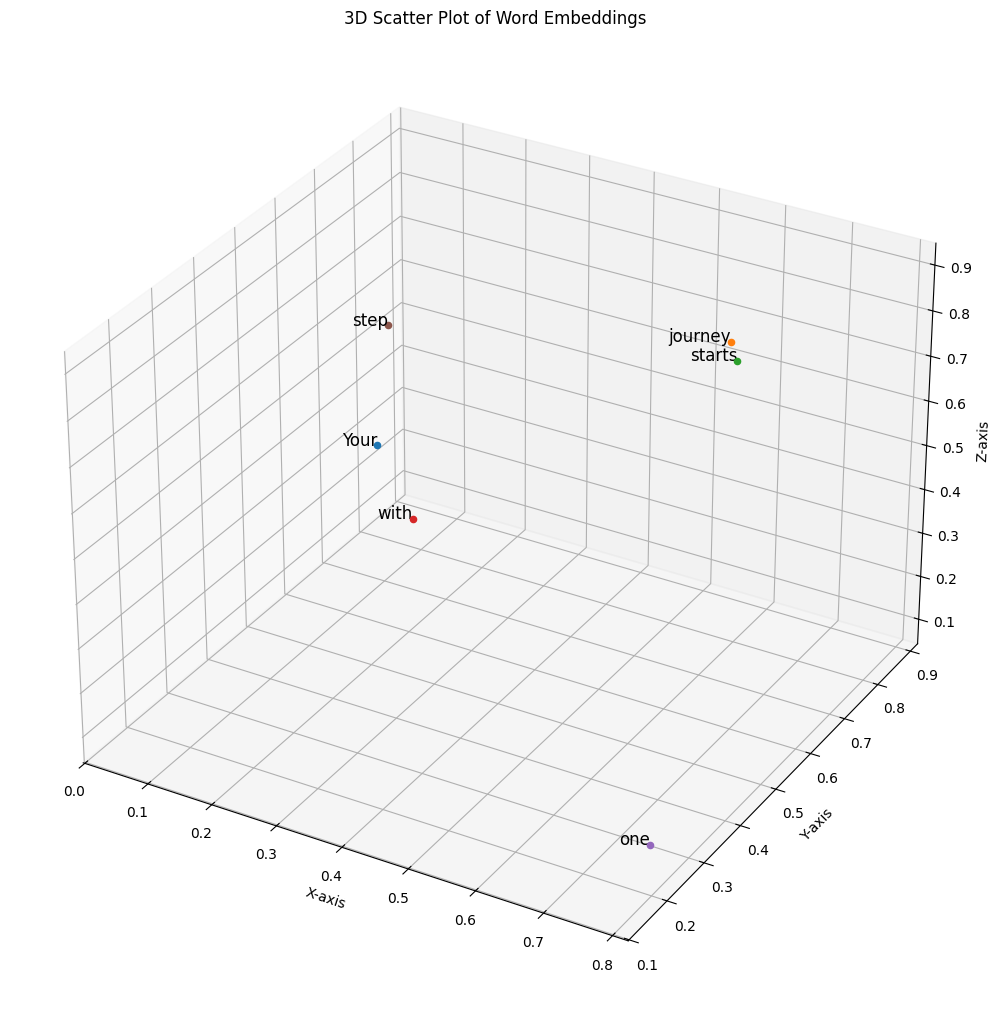

In [35]:
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# Corresponding words.
words = ['Your', 'journey', 'starts', 'with', 'one', 'step']

# Extract x, y, z coordinates.
x_coords = inputs[:, 0].numpy()
y_coords = inputs[:, 1].numpy()
z_coords = inputs[:, 2].numpy()

# Create a 3D scatter plot.
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot each point and annotate with the corresponding word.
for x, y, z, word in zip(x_coords, y_coords, z_coords, words):
    ax.scatter(x, y, z)
    ax.text(x, y, z, word, fontsize=12, ha='right')

# Set labels for axes.
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

plt.title('3D Scatter Plot of Word Embeddings')
plt.tight_layout()
plt.show()

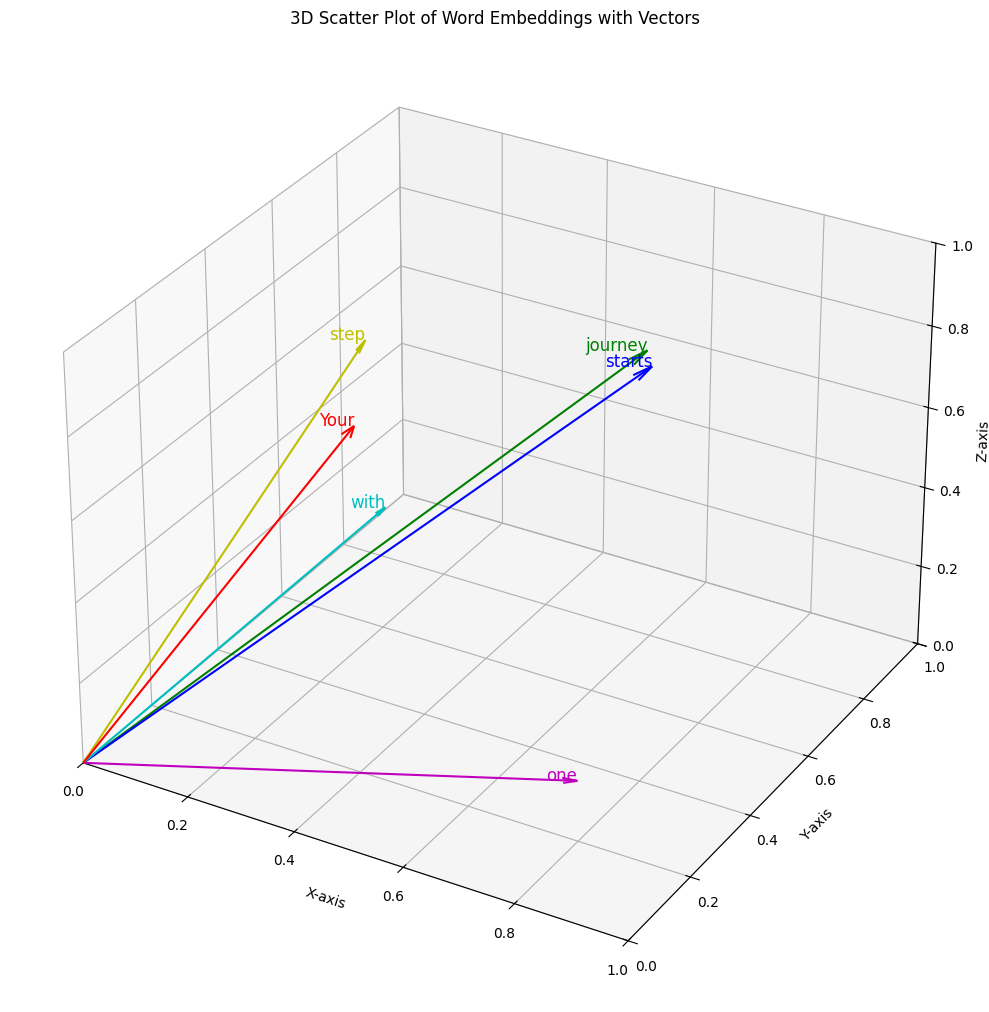

In [36]:
# Create 3D scatter plot with vectors from origin to each point, using different colors.
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')

# Define colors for each point.
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# Plot each vector with a different color and annotate with the corresponding word.
for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words, colors):
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.03)
    ax.text(x, y, z, word, fontsize=12, ha='right', color=color)

# Set labels for axes.
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Set the limits for each axis.
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Scatter Plot of Word Embeddings with Vectors')
plt.tight_layout()
plt.show()

In [37]:
# 2nd example of inputs.
query = inputs[1]
print(f"Input vector: \n{inputs}\n")
print(f"Query/Input vector (x^2): {query}\n")

print(f"Shape of inputs: {inputs.shape}")
print(f"Shape of query: {query.shape}\n")

# Calculate attention scores using dot product.
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)
print(f"{attn_scores_2 = }")
print(f"Shape of attention scores: {attn_scores_2.shape}\n")

# Summation normalisation.
attn_weights_2_sum_norm = attn_scores_2 / attn_scores_2.sum()
print(f"{attn_weights_2_sum_norm = }")
print(f"Sum of attention weights: {attn_weights_2_sum_norm.sum()}\n")

# Naive softmax normalisation.
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)
attn_weights_2_naive_softmax_norm = softmax_naive(attn_scores_2)
print(f"{attn_weights_2_naive_softmax_norm = }")
print(f"Sum of attention weights: {attn_weights_2_naive_softmax_norm.sum()}\n")

# Pytorch softmax normalisation.
attn_weights_2_torch_softmax_norm = torch.softmax(attn_scores_2, dim=0)
print(f"{attn_weights_2_torch_softmax_norm = }")
print(f"Sum of attention weights: {attn_weights_2_torch_softmax_norm.sum()}\n")

# Context vector calculation.
context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2_torch_softmax_norm[i] * x_i
print(f"{context_vec_2 = }")
print(f"Shape of context vector: {context_vec_2.shape}")

Input vector: 
tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])

Query/Input vector (x^2): tensor([0.5500, 0.8700, 0.6600])

Shape of inputs: torch.Size([6, 3])
Shape of query: torch.Size([3])

attn_scores_2 = tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])
Shape of attention scores: torch.Size([6])

attn_weights_2_sum_norm = tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum of attention weights: 1.0000001192092896

attn_weights_2_naive_softmax_norm = tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum of attention weights: 1.0

attn_weights_2_torch_softmax_norm = tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum of attention weights: 1.0

context_vec_2 = tensor([0.4419, 0.6515, 0.5683])
Shape of context vector: torch.Size([3])


In [38]:
# Calculate attention scores using dot product, for entire input.
# attn_scores = torch.empty(6, 6)
attn_scores = torch.empty(inputs.shape[0], inputs.shape[0])
for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)
print(f"Attention score (normal 'for-loop' multiplication):\n{attn_scores}\n")

# Calculate attention scores using matrix multiplication.
attn_scores = inputs @ inputs.T
print(f"Attention score ('matrix' multiplication):\n{attn_scores}\n")

# Normalise attention scores using softmax.
attn_weights = torch.softmax(attn_scores, dim=-1)
print(f"Attention weights (normalised):\n{attn_weights}\n")

row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print(f"{row_2_sum = }")
print(f"All row sums: {attn_weights.sum(dim=-1)}")

Attention score (normal 'for-loop' multiplication):
tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

Attention score ('matrix' multiplication):
tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

Attention weights (normalised):
tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],

In [39]:
print(f"Shape of attention scores: {attn_scores.shape}")
print(f"Shape of attention weights: {attn_weights.shape}")
print(f"Shape of inputs: {inputs.shape}\n")

all_context_vecs = attn_weights @ inputs
print(f"Context vectore:\n{all_context_vecs}\n")
print(f"Shape of context vectors: {all_context_vecs.shape}\n")
print(f"Previous 2nd context vector: {context_vec_2}")

Shape of attention scores: torch.Size([6, 6])
Shape of attention weights: torch.Size([6, 6])
Shape of inputs: torch.Size([6, 3])

Context vectore:
tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])

Shape of context vectors: torch.Size([6, 3])

Previous 2nd context vector: tensor([0.4419, 0.6515, 0.5683])


In [40]:
# Different normalisation methods, extreme values.
import math
x = [1, 2, 3, 400]

x_sum_norm = [xi / sum(x) for xi in x]
print(f"{x_sum_norm = }\n")

x_exp_norm = [math.exp(xi) / sum(math.exp(xi) for xi in x) for xi in x]
print(f"{x_exp_norm = }\n")

x_torch_softmax = torch.softmax(torch.tensor(x, dtype=torch.float32), dim=0)
print(f"{x_torch_softmax = }")

x_sum_norm = [0.0024630541871921183, 0.0049261083743842365, 0.007389162561576354, 0.9852216748768473]

x_exp_norm = [5.205970713164919e-174, 1.4151295589086178e-173, 3.84672096489656e-173, 1.0]

x_torch_softmax = tensor([0., 0., 0., 1.])


What is the difference between the following?

- `torch.softmax(attn_scores, dim=0)`
    - Softmax is applied down each column (along rows).
    - For each column, the values in that column are exponentiated and normalized so the column sums to 1.
    - Each column sums to 1.

- `torch.softmax(attn_scores, dim=1)`
    - Softmax is applied across each row (along columns).
    - For each row, the values in that row are exponentiated and normalized so the row sums to 1.
    - Each row sums to 1.
    - This is the standard for attention mechanisms.

- `torch.softmax(attn_scores, dim=-1)`
    - `dim=-1` means the last dimension (for 2D, same as `dim=1`).
    - Softmax is applied across each row (just like `dim=1` for 2D tensors).
    - Each row sums to 1.

Summary Table:

| Call                            | Softmax Applied On   | Sums to 1?         | Typical for Attention? |
|---------------------------------|----------------------|--------------------|------------------------|
| `torch.softmax(..., dim=0)`     | Down columns         | Each column        | No                     |
| `torch.softmax(..., dim=1)`     | Across rows          | Each row           | Yes                    |
| `torch.softmax(..., dim=-1)`    | Across last axis     | Each row (2D)      | Yes                    |

In attention, you almost always want `dim=1` or `dim=-1` so each row (query) gets a probability distribution over keys.



Self attention (with trainable weights)

In [41]:
# in GPT-like models, the input and output dimensions are usually the same.
x_2 = inputs[1] # The second input element.
d_in = inputs.shape[1] # The input embedding size, d=3.
d_out = 2 #The output embedding size, d_out=2.

torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
print(query_2)

keys = inputs @ W_key
values = inputs @ W_value
print("\nkeys.shape:", keys.shape)
print("values.shape:", values.shape)

tensor([0.4306, 1.4551])

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


In [42]:
keys_2 = keys[1]
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

attn_scores_2 = query_2 @ keys.T
print(attn_scores_2)

d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor(1.8524)
tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])
tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])
tensor([0.3061, 0.8210])


In [43]:
# Why divide by sqrt(d_k)?
# The division by sqrt(d_k) is a scaling factor to prevent the dot product from growing too large, which can lead to numerical instability and saturation of the softmax function.
# This scaling helps to keep the gradients in a reasonable range during training, making the model more stable and easier to optimize.

# Define a tensor.
tensor_x = torch.tensor(data=[0.1, -0.2, 0.3, -0.4, 0.5], dtype=torch.float32)

# Apply softmax without scaling.
softmax_x = torch.softmax(tensor_x, dim=-1)
print(f"Softmax without scaling:\n{softmax_x}\n")

# Multiply the tensor by a large number.
large_number = 10
tensor_x_large = tensor_x * large_number
# Apply softmax without scaling.
softmax_x_large = torch.softmax(tensor_x_large, dim=-1)
print(f"Softmax without scaling (large tensor):\n{softmax_x_large}\n")

# Apply softmax with scaling.
scaled_tensor_x = tensor_x / (5 ** 0.5) # dim = 5, 1 row and 5 columns.
softmax_x_scaled = torch.softmax(scaled_tensor_x, dim=-1)
print(f"Softmax with scaling:\n{softmax_x_scaled}")

# # Apply softmax with scaling on the large tensor.
# scaled_tensor_x_large = tensor_x_large / (5 ** 0.5)
# softmax_x_scaled_large = torch.softmax(scaled_tensor_x_large, dim=-1)
# print(f"Softmax with scaling (large tensor):\n{softmax_x_scaled_large}\n")

Softmax without scaling:
tensor([0.1976, 0.1464, 0.2414, 0.1199, 0.2948])

Softmax without scaling (large tensor):
tensor([1.5862e-02, 7.8972e-04, 1.1721e-01, 1.0688e-04, 8.6604e-01])

Softmax with scaling:
tensor([0.2015, 0.1762, 0.2203, 0.1611, 0.2409])


In [44]:
import numpy as np

# Function to compute variance before and after scaling.
def compute_variance(dim, num_trails=1000):

    dot_products = []
    dot_products_scaled = []

    # Set random seed for reproducibility.
    np.random.seed(14)

    # Generate multiple random vectors and compute dot products.
    for _ in range(num_trails):
        # Generate random vectors.
        _query = np.random.randn(dim)
        _key = np.random.randn(dim)

        # Compute dot product.
        dot_products.append(np.dot(_query, _key))

        # Compute scaled dot product.
        scaled_dot_product = np.dot(_query, _key) / np.sqrt(dim)
        dot_products_scaled.append(scaled_dot_product)

    #  Calculate variance of dot products.
    variance_before_scaling = np.var(dot_products)
    variance_after_scaling = np.var(dot_products_scaled)

    return variance_before_scaling, variance_after_scaling

# Compute variance for different dimensions.
dim = 10
variance_before, variance_after = compute_variance(dim=dim)
print(f"Variance before scaling (dim={dim}): {variance_before}")
print(f"Variance after scaling (dim={dim}): {variance_after}\n")

dim = 100
variance_before, variance_after = compute_variance(dim=dim)
print(f"Variance before scaling (dim={dim}): {variance_before}")
print(f"Variance after scaling (dim={dim}): {variance_after}\n")

dim = 1000
variance_before, variance_after = compute_variance(dim=dim)
print(f"Variance before scaling (dim={dim}): {variance_before}")
print(f"Variance after scaling (dim={dim}): {variance_after}\n")

dim = 10000
variance_before, variance_after = compute_variance(dim=dim)
print(f"Variance before scaling (dim={dim}): {variance_before}")
print(f"Variance after scaling (dim={dim}): {variance_after}")

Variance before scaling (dim=10): 10.407144657637721
Variance after scaling (dim=10): 1.0407144657637724

Variance before scaling (dim=100): 98.32887966875002
Variance after scaling (dim=100): 0.9832887966875001

Variance before scaling (dim=1000): 1084.2805311211634
Variance after scaling (dim=1000): 1.0842805311211634

Variance before scaling (dim=10000): 9914.236775292125
Variance after scaling (dim=10000): 0.9914236775292126


<div>
<img src="_docs/self-attention-full-flow.png" width="800"/><br>
<img src="_docs/self-attention-step1.png" width="800"/><br>
<img src="_docs/self-attention-step2.png" width="800"/><br>
<img src="_docs/self-attention-step3.png" width="800"/><br>
<img src="_docs/self-attention-step4.png" width="800"/><br>
</div>

In [45]:
import torch.nn as nn

# Set seed for reproducibility.
torch.manual_seed(14)

# Create a compact self-attention class.
class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.w_query = nn.Parameter(torch.rand(d_in, d_out))
        self.w_key = nn.Parameter(torch.rand(d_in, d_out))
        self.w_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        # Compute query, key, and value vectors.
        queries = x @ self.w_query
        keys = x @ self.w_key
        values = x @ self.w_value

        # Compute attention scores.
        attn_scores = queries @ keys.T

        # Scale attention scores.
        d_k = keys.shape[-1]
        attn_weights = torch.softmax(attn_scores / d_k**0.5, dim=-1)

        # Compute context vectors.
        context_vecs = attn_weights @ values

        return context_vecs
    
# Create an instance of the self-attention class.
d_in = inputs.shape[1]  # Input embedding size.
d_out = 2  # Output embedding size.
sa_v1 = SelfAttention_v1(d_in=d_in, d_out=d_out)

print(f"'inputs':\n{inputs}\n")
print(f"SelfAttention_v1 for 'inputs':\n{sa_v1(inputs)}")

'inputs':
tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])

SelfAttention_v1 for 'inputs':
tensor([[0.4741, 1.0206],
        [0.4837, 1.0375],
        [0.4831, 1.0363],
        [0.4709, 1.0147],
        [0.4632, 0.9975],
        [0.4782, 1.0289]], grad_fn=<MmBackward0>)


In [46]:
# Set seed for reproducibility.
torch.manual_seed(14)

# Create a self-attention class with PyTorch's Linear layer.
class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.w_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        # Compute query, key, and value vectors.
        queries = self.w_query(x)
        keys = self.w_key(x)
        values = self.w_value(x)

        # Compute attention scores.
        attn_scores = queries @ keys.T

        # Scale attention scores.
        d_k = keys.shape[-1]
        attn_weights = torch.softmax(attn_scores / d_k**0.5, dim=-1)

        # Compute context vectors.
        context_vecs = attn_weights @ values

        return context_vecs
    
# Create an instance of the self-attention class with PyTorch's Linear layer.
d_in = inputs.shape[1]  # Input embedding size.
d_out = 2  # Output embedding size.
sa_v2 = SelfAttention_v2(d_in=d_in, d_out=d_out)

print(f"'inputs':\n{inputs}\n")
print(f"SelfAttention_v2 for 'inputs':\n{sa_v2(inputs)}")

'inputs':
tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])

SelfAttention_v2 for 'inputs':
tensor([[ 0.0963, -0.1460],
        [ 0.0963, -0.1459],
        [ 0.0963, -0.1460],
        [ 0.0988, -0.1522],
        [ 0.0988, -0.1521],
        [ 0.0981, -0.1503]], grad_fn=<MmBackward0>)


Causal attention

<div>
<img src="_docs/triangular-matrix.jpeg" width="800"/>
</div>

In [47]:
print(f"'inputs':\n{inputs}\n")

queries = sa_v2.w_query(inputs)
keys = sa_v2.w_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(f"Attention weights (normalised):\n {attn_weights}\n")

context_length = attn_scores.shape[0]
# tril - lower triangular matrix. 
# triu - upper triangular matrix.
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(f"Simple mask to apply on attention weights:\n{mask_simple}")

'inputs':
tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])

Attention weights (normalised):
 tensor([[0.1883, 0.1539, 0.1540, 0.1692, 0.1685, 0.1660],
        [0.1918, 0.1644, 0.1644, 0.1577, 0.1640, 0.1576],
        [0.1915, 0.1644, 0.1644, 0.1578, 0.1641, 0.1578],
        [0.1795, 0.1674, 0.1674, 0.1603, 0.1646, 0.1607],
        [0.1788, 0.1649, 0.1650, 0.1629, 0.1657, 0.1627],
        [0.1834, 0.1673, 0.1673, 0.1587, 0.1641, 0.1592]],
       grad_fn=<SoftmaxBackward0>)

Simple mask to apply on attention weights:
tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [48]:
masked_simple = attn_weights*mask_simple
print(f"Attention weights after applying mask:\n{masked_simple}\n")

row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(f"Attention weights renormalised after masking:\n{masked_simple_norm}")

Attention weights after applying mask:
tensor([[0.1883, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1918, 0.1644, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1915, 0.1644, 0.1644, 0.0000, 0.0000, 0.0000],
        [0.1795, 0.1674, 0.1674, 0.1603, 0.0000, 0.0000],
        [0.1788, 0.1649, 0.1650, 0.1629, 0.1657, 0.0000],
        [0.1834, 0.1673, 0.1673, 0.1587, 0.1641, 0.1592]],
       grad_fn=<MulBackward0>)

Attention weights renormalised after masking:
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5386, 0.4614, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3681, 0.3159, 0.3160, 0.0000, 0.0000, 0.0000],
        [0.2661, 0.2482, 0.2482, 0.2375, 0.0000, 0.0000],
        [0.2135, 0.1970, 0.1970, 0.1946, 0.1979, 0.0000],
        [0.1834, 0.1673, 0.1673, 0.1587, 0.1641, 0.1592]],
       grad_fn=<DivBackward0>)


In [49]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
print(f"Simple mask to apply on attention scores:\n{mask}\n")

masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(f"Attention scores masked and filled (replaced):\n{masked}\n")

attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(f"Attention weights after masking and softmax:\n{attn_weights}\n")

print(f"Sum of each row in attention weights:\n{attn_weights.sum(dim=-1)}")

Simple mask to apply on attention scores:
tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])

Attention scores masked and filled (replaced):
tensor([[-0.0625,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 0.2607,  0.0422,    -inf,    -inf,    -inf,    -inf],
        [ 0.2567,  0.0404,  0.0409,    -inf,    -inf,    -inf],
        [ 0.1854,  0.0870,  0.0870,  0.0250,    -inf,    -inf],
        [ 0.1113, -0.0027, -0.0024, -0.0203,  0.0039,    -inf],
        [ 0.2318,  0.1018,  0.1019,  0.0268,  0.0748,  0.0313]],
       grad_fn=<MaskedFillBackward0>)

Attention weights after masking and softmax:
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5386, 0.4614, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3681, 0.3159, 0.3160, 0.0000, 0.0000, 0.0000],
        [0.2661, 0.2482, 0.2482, 0.2375, 0.0000, 0.0000],
    

Why `triu` is used, instead of `tril`?

```python
print(f"attn_scores:\n{attn_scores}\n")
print(f"mask_simple:\n{mask_simple}\n")

attn_scores_masked = attn_scores * mask_simple
print(f"attn_scores * mask_simple:\n{attn_scores_masked}\n")

attn_weights_masked = torch.softmax(attn_scores_masked, dim=-1)
print(f"Attention weights after simple masking and softmax:\n{attn_weights_masked}\n")

print(f"Sum of each row in attention weights:\n{attn_weights.sum(dim=-1)}\n")
```
```
attn_scores:
tensor([[-0.0625, -0.3480, -0.3464, -0.2135, -0.2192, -0.2407],
        [ 0.2607,  0.0422,  0.0426, -0.0164,  0.0392, -0.0172],
        [ 0.2567,  0.0404,  0.0409, -0.0168,  0.0379, -0.0177],
        [ 0.1854,  0.0870,  0.0870,  0.0250,  0.0633,  0.0291],
        [ 0.1113, -0.0027, -0.0024, -0.0203,  0.0039, -0.0223],
        [ 0.2318,  0.1018,  0.1019,  0.0268,  0.0748,  0.0313]],
       grad_fn=<MmBackward0>)

mask_simple:
tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])

attn_scores * mask_simple:
tensor([[-0.0625, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000],
        [ 0.2607,  0.0422,  0.0000, -0.0000,  0.0000, -0.0000],
        [ 0.2567,  0.0404,  0.0409, -0.0000,  0.0000, -0.0000],
        [ 0.1854,  0.0870,  0.0870,  0.0250,  0.0000,  0.0000],
        [ 0.1113, -0.0027, -0.0024, -0.0203,  0.0039, -0.0000],
        [ 0.2318,  0.1018,  0.1019,  0.0268,  0.0748,  0.0313]],
       grad_fn=<MulBackward0>)

Attention weights after simple masking and softmax:
tensor([[0.1582, 0.1684, 0.1684, 0.1684, 0.1684, 0.1684],
        [0.2047, 0.1645, 0.1577, 0.1577, 0.1577, 0.1577],
        [0.2027, 0.1633, 0.1634, 0.1568, 0.1568, 0.1568],
        [0.1878, 0.1702, 0.1702, 0.1599, 0.1560, 0.1560],
        [0.1833, 0.1636, 0.1636, 0.1607, 0.1647, 0.1640],
        [0.1907, 0.1675, 0.1675, 0.1554, 0.1630, 0.1561]],
       grad_fn=<SoftmaxBackward0>)

Sum of each row in attention weights:
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)
```

In this approach, the values that we wanted to mask in the `attention_weights` matrix do carry information and is __NOT Zero__.

In [50]:
torch.manual_seed(14)
dropout = torch.nn.Dropout(p=0.5) # Set dropout probability to 50%.
example = torch.ones(6, 6) # Example tensor to apply dropout on.
print(f"Example tensor before dropout:\n{example}\n")
print(f"Example tensor after dropout:\n{dropout(example)}")

Example tensor before dropout:
tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

Example tensor after dropout:
tensor([[0., 2., 0., 2., 2., 2.],
        [0., 0., 2., 2., 0., 0.],
        [0., 2., 0., 2., 0., 2.],
        [0., 0., 0., 0., 0., 0.],
        [2., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 2., 0.]])


The outputs are scaled by a factor of `1/(1-p)` during training. More details can be found [here](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html).

In [51]:
torch.manual_seed(14)
print(f"Attention weights before dropout:\n{attn_weights}\n")
print(f"Attention weights after dropout:\n{dropout(attn_weights)}")

Attention weights before dropout:
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5386, 0.4614, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3681, 0.3159, 0.3160, 0.0000, 0.0000, 0.0000],
        [0.2661, 0.2482, 0.2482, 0.2375, 0.0000, 0.0000],
        [0.2135, 0.1970, 0.1970, 0.1946, 0.1979, 0.0000],
        [0.1834, 0.1673, 0.1673, 0.1587, 0.1641, 0.1592]],
       grad_fn=<SoftmaxBackward0>)

Attention weights after dropout:
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6318, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4270, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3283, 0.0000]],
       grad_fn=<MulBackward0>)


In [52]:
# Create a batch of inputs by stacking two copies of the same input tensor.
batch = torch.stack((inputs, inputs), dim=0)
print(f"Batch of inputs:\n{batch}\n")
print(f"Shape of the batch: {batch.shape}\n")

# Implement a compact causal attention class.
class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.w_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.context_length = context_length
        self.dropout = nn.Dropout(p=dropout)
        self.register_buffer(
            name='mask', 
            tensor=torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape # Batch size, number of tokens, and input dimension.
        # Here, batch size (b) and input dimension (d_in) are not used, but they can be useful for further processing.
        
        # Compute query, key, and value vectors.
        queries = self.w_query(x)
        keys = self.w_key(x)
        values = self.w_value(x)

        # Compute attention scores.
        attn_scores = queries @ keys.transpose(1, 2) # Transpose dimensions 1 and 2, keeping the batch dimension at the first position (0).
        
        # Mask attention scores using the pre-defined mask.
        # In PyTorch, operations with a trailing underscore are performed in-place, avoiding unnecessary memory copies.
        attn_scores.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf 
        )

        # Normalise attention scores.
        attn_weights = torch.softmax(input=attn_scores / keys.shape[-1]**0.5, dim=-1)

        # Apply dropout to attention weights.
        attn_weights = self.dropout(attn_weights)

        # Compute context vectors.
        context_vecs = attn_weights @ values

        return context_vecs

Batch of inputs:
tensor([[[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]],

        [[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]]])

Shape of the batch: torch.Size([2, 6, 3])



| Variable        | Shape                        | Meaning                                  |
|-----------------|-----------------------------|------------------------------------------|
| `batch`         | (b, num_tokens, d_in)       | Input batch of sequences                 |
| `queries`       | (b, num_tokens, d_out)      | Projected queries per batch              |
| `keys`          | (b, num_tokens, d_out)      | Projected keys per batch                 |
| `attn_scores`   | (b, num_tokens, num_tokens) | Attention scores per batch               |
| `attn_weights`  | (b, num_tokens, num_tokens) | Normalized attention weights per batch   |
| `values`        | (b, num_tokens, d_out)      | Projected values per batch               |
| `context_vecs`  | (b, num_tokens, d_out)      | Output context vectors per batch         |

In [53]:
torch.manual_seed(123)

context_length = batch.shape[1] # Context length is the number of tokens in the input sequence.
d_in = batch.shape[-1]  # Input embedding size.
d_out = 2  # Output embedding size.

# Create an instance of the CausalAttention class.
ca = CausalAttention(d_in=d_in, d_out=d_out, context_length=context_length, dropout=0.0)

# Calcuate context vectors for the batch of inputs.
context_vecs = ca(batch)
print(f"Context vectors for the batch of inputs:\n{context_vecs}\n")
print(f"Shape of context vectors: {context_vecs.shape}")

Context vectors for the batch of inputs:
tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)

Shape of context vectors: torch.Size([2, 6, 2])


__How does the class know that the inputs are in batches?__

The class knows the inputs are in batches because of the shape of the input tensor you pass to it.

When you call:

```python
context_vecs = ca(batch)
```

your `batch` tensor has shape (batch_size, num_tokens, d_in), for example `(2, 6, 3)`.

Inside the `forward` method:

```python
b, num_tokens, d_in = x.shape
```

PyTorch automatically handles the first dimension `(b)` as the batch size. All operations (like linear layers and matrix multiplications) are __vectorized__ to work on each batch independently.

- The `nn.Linear` layers (`self.w_query`, etc.) are designed to process the batch dimension automatically.
- Matrix multiplications like `queries @ keys.transpose(1, 2)` are performed for each batch in parallel.

_Summary:_

The class doesn't need any special code to "know" about batches—PyTorch's tensor operations and layers always treat the first dimension as the batch, and process all batches in parallel. The shape of the input tells the class how many batches there are.

Multi-head attention

<div>
<img src="_docs/multihead-attention-01.png" width="800"/><br>
<img src="_docs/multihead-attention-02.png" width="800"/><br>
</div>

In [54]:
# Wrapper class to implement multi-head attention.
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length,
                 dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            modules=[
                CausalAttention(
                    d_in=d_in, d_out=d_out, context_length=context_length,
                    dropout=dropout, qkv_bias=qkv_bias
                )
                for _ in range(num_heads)
            ]
        )

    def forward(self, x):
        # Concatenate context vectors from all heads along the last dimension.
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [55]:
print(f"Input batch:\n{batch}\n")
print(f"Shape of the input batch: {batch.shape}")

Input batch:
tensor([[[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]],

        [[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]]])

Shape of the input batch: torch.Size([2, 6, 3])


In [56]:
torch.manual_seed(14)
context_length = batch.shape[1] # Number of tokens.
d_in, d_out = 3, 2
num_heads = 3 # Number of attention heads.

# Create an instance of the MultiHeadAttention class.
mhaw = MultiHeadAttentionWrapper(
    d_in=d_in, d_out=d_out, context_length=context_length,
    dropout=0.0, num_heads=num_heads
)

# Calculate context vectors for the batch of inputs.
context_vecs = mhaw(batch)
print(f"Context vectors for the batch of inputs:\n{context_vecs}\n")
print(f"Shape of context vectors: {context_vecs.shape}")

Context vectors for the batch of inputs:
tensor([[[-0.0430,  0.2785,  0.3550,  0.2952,  0.3919, -0.2866],
         [ 0.0550,  0.0223,  0.2980,  0.3787,  0.4385, -0.2164],
         [ 0.0883, -0.0746,  0.2801,  0.4013,  0.4448, -0.1903],
         [ 0.1034, -0.1121,  0.2310,  0.3728,  0.4086, -0.1674],
         [ 0.0730, -0.1552,  0.2312,  0.2970,  0.3114, -0.1030],
         [ 0.0981, -0.1503,  0.2038,  0.3307,  0.3417, -0.1192]],

        [[-0.0430,  0.2785,  0.3550,  0.2952,  0.3919, -0.2866],
         [ 0.0550,  0.0223,  0.2980,  0.3787,  0.4385, -0.2164],
         [ 0.0883, -0.0746,  0.2801,  0.4013,  0.4448, -0.1903],
         [ 0.1034, -0.1121,  0.2310,  0.3728,  0.4086, -0.1674],
         [ 0.0730, -0.1552,  0.2312,  0.2970,  0.3114, -0.1030],
         [ 0.0981, -0.1503,  0.2038,  0.3307,  0.3417, -0.1192]]],
       grad_fn=<CatBackward0>)

Shape of context vectors: torch.Size([2, 6, 6])


Multi-head attention with weight splits

<div>
<img src="_docs/multihead-attention-03.png" width="800"/>
</div>

In [57]:
torch.manual_seed(14)

b = 2 # Batch size.
context_length = 4 # Number of tokens.
d_in = d_out = 6 # Input and output embedding sizes.
test_input = torch.randn(b, context_length, d_in).round(decimals=2)
print(f"Input tensor shape: {test_input.shape}")
print(f"Input tensor:\n{test_input}\n") 

Input tensor shape: torch.Size([2, 4, 6])
Input tensor:
tensor([[[-0.3400, -0.1000,  1.4000,  0.7800, -1.1800,  0.2500],
         [-0.3500,  0.1200,  1.2500, -0.0200,  1.8400, -1.4100],
         [ 1.4700, -1.6900,  0.0400,  0.5500,  0.2600, -2.1500],
         [-1.4300,  0.1000, -0.5200,  2.2900,  0.1400, -0.7400]],

        [[-0.0700,  2.0300, -0.0300, -1.0800,  0.9800,  0.8000],
         [-1.3800,  0.5800,  0.9400, -0.7300,  0.6800, -0.4200],
         [ 0.6200, -0.0500, -0.8400, -1.8700, -1.3300, -0.7100],
         [ 1.6800,  1.6900, -1.2400, -0.0900, -0.4400, -0.1500]]])



In [58]:
torch.manual_seed(14)

num_heads = 2 # Number of attention heads.
dim_head = d_out // num_heads # Output embedding size per head.

w_query = torch.randn(d_in, d_out).round(decimals=2)
w_key = torch.randn(d_in, d_out).round(decimals=2)
w_value = torch.randn(d_in, d_out).round(decimals=2)

print(f"Each head's dimension: {d_in, dim_head}\n")
print(f"Test query shape: {w_query.shape}")
print(f"Test query:\n{w_query}\n")
print(f"Test key shape: {w_key.shape}")
print(f"Test key:\n{w_key}\n")
print(f"Test value shape: {w_value.shape}\n")
print(f"Test value:\n{w_value}\n")

Each head's dimension: (6, 3)

Test query shape: torch.Size([6, 6])
Test query:
tensor([[-0.3400, -0.1000,  1.4000,  0.7800, -1.1800,  0.2500],
        [-0.3500,  0.1200,  1.2500, -0.0200,  1.8400, -1.4100],
        [ 1.4700, -1.6900,  0.0400,  0.5500,  0.2600, -2.1500],
        [-1.4300,  0.1000,  0.6200, -0.0500, -0.8400, -1.8700],
        [-0.2600,  0.3000,  0.6100, -0.1100, -1.2400, -0.0900],
        [-0.4400, -0.1500,  1.9200, -1.3700, -0.2200, -0.8200]])

Test key shape: torch.Size([6, 6])
Test key:
tensor([[ 0.2900, -0.3900, -0.3400,  1.2800,  0.9800,  2.2200],
        [ 1.0600, -0.4700,  1.1300, -0.2800,  0.5600, -1.5100],
        [ 0.9200, -0.5600, -0.2600,  1.3200, -0.0100,  0.0100],
        [-0.3200, -1.7400,  0.2700, -0.0100, -1.3400,  0.5200],
        [ 1.2800,  0.7300, -0.5100,  0.2400,  2.0200, -0.1600],
        [-0.7600, -0.0000, -0.8900,  0.2100,  0.4800, -0.7500]])

Test value shape: torch.Size([6, 6])

Test value:
tensor([[ 1.0200, -1.2600, -0.8700, -0.2000,  0.2300,

In [59]:
test_query = test_input @ w_query
test_keys = test_input @ w_key
test_values = test_input @ w_value

print(f"Test query shape: {test_query.shape}")
print(f"Test query:\n{test_query}\n")
print(f"Test keys shape: {test_keys.shape}")
print(f"Test keys:\n{test_keys}\n")
print(f"Test values shape: {test_values.shape}\n")
print(f"Test values:\n{test_values}\n")


Test query shape: torch.Size([2, 4, 6])
Test query:
tensor([[[ 1.2900, -2.6575, -0.3012,  0.2551,  1.3342, -4.5114],
         [ 2.0851, -1.3016, -1.8872,  2.1424, -0.9958, -1.9162],
         [ 0.2424,  0.0381, -3.6813,  4.0918, -5.1452,  3.3755],
         [-3.2987,  1.4158, -1.8134, -0.5195, -0.1982, -3.0686]],

        [[ 0.2068,  0.3673,  3.9025, -1.2615,  3.3260, -1.5399],
         [ 2.6999, -1.1870, -2.0136, -0.0339,  2.8024, -1.5355],
         [ 1.9042,  0.8721, -2.5620,  1.2351,  2.3342,  6.2303],
         [-2.6764,  2.0119,  3.8027,  0.8530,  1.4590,  1.0340]]])

Test keys shape: torch.Size([2, 4, 6])
Test keys:
tensor([[[-0.8666, -2.8230,  0.2285,  1.2023, -3.7120, -0.1829],
         [ 4.6089,  0.7581,  0.2407,  1.3141,  2.7785, -0.1930],
         [ 0.4625, -0.5686, -0.4905,  2.0130, -0.7500,  7.6726],
         [-0.7783, -3.0805,  1.9399, -2.6895, -4.4812, -1.6074]],

        [[ 3.0959,  1.6846,  0.8221, -0.2836,  4.8793, -4.5394],
         [ 2.5026,  1.5058,  0.7101, -0.6057, 

In [60]:
# Reshape the test query, keys, and values for multi-head attention.
query = test_query.reshape(b, context_length, num_heads, dim_head)
keys = test_keys.reshape(b, context_length, num_heads, dim_head)
values = test_values.reshape(b, context_length, num_heads, dim_head)

print(f"Test query shape after reshaping: {query.shape}")
print(f"Test query after reshaping:\n{query}\n")
print(f"Test keys shape after reshaping: {keys.shape}")
print(f"Test keys after reshaping:\n{keys}\n")
print(f"Test values shape after reshaping: {values.shape}")
print(f"Test values after reshaping:\n{values}\n")

Test query shape after reshaping: torch.Size([2, 4, 2, 3])
Test query after reshaping:
tensor([[[[ 1.2900, -2.6575, -0.3012],
          [ 0.2551,  1.3342, -4.5114]],

         [[ 2.0851, -1.3016, -1.8872],
          [ 2.1424, -0.9958, -1.9162]],

         [[ 0.2424,  0.0381, -3.6813],
          [ 4.0918, -5.1452,  3.3755]],

         [[-3.2987,  1.4158, -1.8134],
          [-0.5195, -0.1982, -3.0686]]],


        [[[ 0.2068,  0.3673,  3.9025],
          [-1.2615,  3.3260, -1.5399]],

         [[ 2.6999, -1.1870, -2.0136],
          [-0.0339,  2.8024, -1.5355]],

         [[ 1.9042,  0.8721, -2.5620],
          [ 1.2351,  2.3342,  6.2303]],

         [[-2.6764,  2.0119,  3.8027],
          [ 0.8530,  1.4590,  1.0340]]]])

Test keys shape after reshaping: torch.Size([2, 4, 2, 3])
Test keys after reshaping:
tensor([[[[-0.8666, -2.8230,  0.2285],
          [ 1.2023, -3.7120, -0.1829]],

         [[ 4.6089,  0.7581,  0.2407],
          [ 1.3141,  2.7785, -0.1930]],

         [[ 0.4625, -0.5

A __contiguous tensor__ in PyTorch means that the data is stored in a single, continuous chunk of memory, with no gaps or jumps between elements. This is important for some operations (like `.view()`) that rely on the underlying memory layout.

- _Why does it matter?_

    Some tensor operations (like slicing, transposing, or certain advanced indexing) can create non-contiguous tensors. These tensors still work for most operations, but some methods (like `.view()`) require the tensor to be contiguous for efficiency and correctness.

- _How to check?_

    You can check if a tensor is contiguous with `.is_contiguous()`:

    ```python
    print(tensor.is_contiguous())
    ```

- _How to make a tensor contiguous?_

    Use `.contiguous()` to get a contiguous copy:
    ```python
    tensor = tensor.contiguous()
    ```

- _Why does `.reshape()` work?_

    `.reshape()` is more flexible: if the tensor is not contiguous, it will automatically make a contiguous copy if needed, so it works in more cases than `.view()`.

__Summary:__

A contiguous tensor has its elements stored in an unbroken block of memory. Some operations require this for efficiency. If you get a "not contiguous" error, use `.reshape()` or `.contiguous()` to fix it.

In [61]:
# Reshape the test query, keys, and values for multi-head attention.
query = test_query.contiguous().view(b, context_length, num_heads, dim_head)
keys = test_keys.contiguous().view(b, context_length, num_heads, dim_head)
values = test_values.contiguous().view(b, context_length, num_heads, dim_head)

print(f"Test query shape after reshaping: {query.shape}")
print(f"Test query after reshaping:\n{query}\n")
print(f"Test keys shape after reshaping: {keys.shape}")
print(f"Test keys after reshaping:\n{keys}\n")
print(f"Test values shape after reshaping: {values.shape}")
print(f"Test values after reshaping:\n{values}\n")

Test query shape after reshaping: torch.Size([2, 4, 2, 3])
Test query after reshaping:
tensor([[[[ 1.2900, -2.6575, -0.3012],
          [ 0.2551,  1.3342, -4.5114]],

         [[ 2.0851, -1.3016, -1.8872],
          [ 2.1424, -0.9958, -1.9162]],

         [[ 0.2424,  0.0381, -3.6813],
          [ 4.0918, -5.1452,  3.3755]],

         [[-3.2987,  1.4158, -1.8134],
          [-0.5195, -0.1982, -3.0686]]],


        [[[ 0.2068,  0.3673,  3.9025],
          [-1.2615,  3.3260, -1.5399]],

         [[ 2.6999, -1.1870, -2.0136],
          [-0.0339,  2.8024, -1.5355]],

         [[ 1.9042,  0.8721, -2.5620],
          [ 1.2351,  2.3342,  6.2303]],

         [[-2.6764,  2.0119,  3.8027],
          [ 0.8530,  1.4590,  1.0340]]]])

Test keys shape after reshaping: torch.Size([2, 4, 2, 3])
Test keys after reshaping:
tensor([[[[-0.8666, -2.8230,  0.2285],
          [ 1.2023, -3.7120, -0.1829]],

         [[ 4.6089,  0.7581,  0.2407],
          [ 1.3141,  2.7785, -0.1930]],

         [[ 0.4625, -0.5

In [62]:
# Transposes from shape (b, context_length, num_heads, dim_head) to (b, num_heads, context_length, dim_head)
query = test_query.view(b, context_length, num_heads, dim_head).transpose(1, 2)
keys = test_keys.view(b, context_length, num_heads, dim_head).transpose(1, 2)
values = test_values.view(b, context_length, num_heads, dim_head).transpose(1, 2)

print(f"Test query shape after reshaping: {query.shape}")
print(f"Test query after reshaping:\n{query}\n")
print(f"Test keys shape after reshaping: {keys.shape}")
print(f"Test keys after reshaping:\n{keys}\n")
print(f"Test values shape after reshaping: {values.shape}")
print(f"Test values after reshaping:\n{values}\n")

Test query shape after reshaping: torch.Size([2, 2, 4, 3])
Test query after reshaping:
tensor([[[[ 1.2900, -2.6575, -0.3012],
          [ 2.0851, -1.3016, -1.8872],
          [ 0.2424,  0.0381, -3.6813],
          [-3.2987,  1.4158, -1.8134]],

         [[ 0.2551,  1.3342, -4.5114],
          [ 2.1424, -0.9958, -1.9162],
          [ 4.0918, -5.1452,  3.3755],
          [-0.5195, -0.1982, -3.0686]]],


        [[[ 0.2068,  0.3673,  3.9025],
          [ 2.6999, -1.1870, -2.0136],
          [ 1.9042,  0.8721, -2.5620],
          [-2.6764,  2.0119,  3.8027]],

         [[-1.2615,  3.3260, -1.5399],
          [-0.0339,  2.8024, -1.5355],
          [ 1.2351,  2.3342,  6.2303],
          [ 0.8530,  1.4590,  1.0340]]]])

Test keys shape after reshaping: torch.Size([2, 2, 4, 3])
Test keys after reshaping:
tensor([[[[-0.8666, -2.8230,  0.2285],
          [ 4.6089,  0.7581,  0.2407],
          [ 0.4625, -0.5686, -0.4905],
          [-0.7783, -3.0805,  1.9399]],

         [[ 1.2023, -3.7120, -0.18

In [63]:
# Attention scores calculation.
attn_scores = query @ keys.transpose(-2, -1)  # Transpose the last two dimensions.
print(f"Attention scores shape: {attn_scores.shape}")
print(f"Attention scores:\n{attn_scores}\n")

Attention scores shape: torch.Size([2, 2, 4, 4])
Attention scores:
tensor([[[[  6.3154,   3.8583,   2.2554,   6.5981],
          [  1.4362,   8.1690,   2.6301,  -1.2742],
          [ -1.1588,   0.2600,   1.8961,  -7.4474],
          [ -1.5525, -14.5665,  -1.4412,  -5.3118]],

         [[ -3.8207,   4.9130, -35.1013,   0.5867],
          [  6.6227,   0.4183,  -9.6427,   1.7805],
          [ 23.4012,  -9.5704,  37.9946,   6.6260],
          [  0.6724,  -0.6411, -24.4412,   7.2178]]],


        [[[  4.4672,   3.8418,   3.6326,   7.5941],
          [  4.7036,   3.5395,  -7.8001,  -0.9875],
          [  5.2581,   4.2594,  -2.0320,  -4.5459],
          [ -1.7704,  -0.9681,  11.2160,   3.8141]],

         [[ 23.5765,  10.7854,  -0.7052,   3.9872],
          [ 20.6536,   9.4409,  -1.6563,   2.9512],
          [-17.2428, -23.7151,   6.8062,  12.1097],
          [  2.1832,  -3.1354,   0.7142,   3.8391]]]])



In [64]:
# Masking and softmax normalisation are not applied in this example.
# For simplicity, assume 'attn_scores' = 'attn_weights'.
attn_weights = attn_scores

# Calculate context vectors.
context_vecs = attn_weights @ values
print(f"Context vectors shape (w/o transpose): {context_vecs.shape}")
print(f"Context vectors (w/o transpose):\n{context_vecs}\n")

Context vectors shape (w/o transpose): torch.Size([2, 2, 4, 3])
Context vectors (w/o transpose):
tensor([[[[   9.2386,    2.1924,  -15.1032],
          [ -10.2965,   -3.1268,  -15.3079],
          [ -18.6148,  -10.7854,   -4.3460],
          [  -2.2087,   -8.7381,   17.5103]],

         [[ 104.5964,  -53.5264, -262.4267],
          [  24.5155,   -6.2680,  -66.6829],
          [-129.5448,   75.7481,  300.5123],
          [  60.0396,  -40.0547, -174.8888]]],


        [[[  20.6329,  -29.1379,   53.8305],
          [ -20.5361,   26.3268,    8.5094],
          [ -42.7120,   29.2376,   18.1023],
          [  22.7003,  -39.3194,   24.5415]],

         [[  71.9585,  -37.4511, -212.5066],
          [  63.0770,  -30.6614, -186.8075],
          [ -72.0320,   -8.7111,  225.3027],
          [   1.6352,  -11.1040,   -1.9872]]]])



In [65]:
context_vecs = (attn_weights @ values).transpose(1, 2)
print(f"Context vectors shape (w/ transpose): {context_vecs.shape}")
print(f"Context vectors (w/ transpose):\n{context_vecs}\n")

Context vectors shape (w/ transpose): torch.Size([2, 4, 2, 3])
Context vectors (w/ transpose):
tensor([[[[   9.2386,    2.1924,  -15.1032],
          [ 104.5964,  -53.5264, -262.4267]],

         [[ -10.2965,   -3.1268,  -15.3079],
          [  24.5155,   -6.2680,  -66.6829]],

         [[ -18.6148,  -10.7854,   -4.3460],
          [-129.5448,   75.7481,  300.5123]],

         [[  -2.2087,   -8.7381,   17.5103],
          [  60.0396,  -40.0547, -174.8888]]],


        [[[  20.6329,  -29.1379,   53.8305],
          [  71.9585,  -37.4511, -212.5066]],

         [[ -20.5361,   26.3268,    8.5094],
          [  63.0770,  -30.6614, -186.8075]],

         [[ -42.7120,   29.2376,   18.1023],
          [ -72.0320,   -8.7111,  225.3027]],

         [[  22.7003,  -39.3194,   24.5415],
          [   1.6352,  -11.1040,   -1.9872]]]])



In [66]:
context_vecs = (attn_weights @ values).transpose(1, 2)

# Combine heads, d_out = num_heads * dim_head.
context_vecs = context_vecs.contiguous().view(b, context_length, d_out)  # Flatten the last two dimensions.
print(f"Context vectors shape (after combining heads): {context_vecs.shape}")
print(f"Context vectors (after combining heads):\n{context_vecs}\n")

Context vectors shape (after combining heads): torch.Size([2, 4, 6])
Context vectors (after combining heads):
tensor([[[   9.2386,    2.1924,  -15.1032,  104.5964,  -53.5264, -262.4267],
         [ -10.2965,   -3.1268,  -15.3079,   24.5155,   -6.2680,  -66.6829],
         [ -18.6148,  -10.7854,   -4.3460, -129.5448,   75.7481,  300.5123],
         [  -2.2087,   -8.7381,   17.5103,   60.0396,  -40.0547, -174.8888]],

        [[  20.6329,  -29.1379,   53.8305,   71.9585,  -37.4511, -212.5066],
         [ -20.5361,   26.3268,    8.5094,   63.0770,  -30.6614, -186.8075],
         [ -42.7120,   29.2376,   18.1023,  -72.0320,   -8.7111,  225.3027],
         [  22.7003,  -39.3194,   24.5415,    1.6352,  -11.1040,   -1.9872]]])



In [67]:
print(f"'query' shape (b, num_heads, context_length, dim_head): {query.shape}\n")

print(f"'keys' shape (b, num_heads, context_length, dim_head): {keys.shape}")
print(f"'keys.transpose(-2, -1)' shape (b, num_heads, dim_head, context_length): {keys.transpose(-2, -1).shape}\n")

print(f"'values' shape (b, num_heads, context_length, dim_head): {values.shape}\n")

print(f"'attn_scores' shape (b, num_heads, context_length, context_length): {attn_scores.shape}\n")

print(f"'context_vecs' shape, before transpose, (b, num_heads, context_length, dim_head): {(attn_weights @ values).shape}")
print(f"'context_vecs' shape, after transpose, (b, context_length, num_heads, dim_head): {(attn_weights @ values).transpose(1, 2).shape}")
print(f"'context_vecs' shape, after combining heads, (b, context_length, d_out): {context_vecs.shape}")

'query' shape (b, num_heads, context_length, dim_head): torch.Size([2, 2, 4, 3])

'keys' shape (b, num_heads, context_length, dim_head): torch.Size([2, 2, 4, 3])
'keys.transpose(-2, -1)' shape (b, num_heads, dim_head, context_length): torch.Size([2, 2, 3, 4])

'values' shape (b, num_heads, context_length, dim_head): torch.Size([2, 2, 4, 3])

'attn_scores' shape (b, num_heads, context_length, context_length): torch.Size([2, 2, 4, 4])

'context_vecs' shape, before transpose, (b, num_heads, context_length, dim_head): torch.Size([2, 2, 4, 3])
'context_vecs' shape, after transpose, (b, context_length, num_heads, dim_head): torch.Size([2, 4, 2, 3])
'context_vecs' shape, after combining heads, (b, context_length, d_out): torch.Size([2, 4, 6])


In [73]:
# An efficient implementation of multi-head attention.
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.context_length = context_length
        self.num_heads = num_heads
        self.dim_head = d_out // num_heads # Reduces the projection dim to match the desired output dim.

        self.w_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out) # Use a Linear layer to combine head outputs.
        self.dropout = nn.Dropout(p=dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        
        # # Compute query, key, and value vectors.
        queries = self.w_query(x)
        keys = self.w_key(x)
        values = self.w_value(x)

        # Implicitly split the matrix by adding a num_heads dimension. 
        # Then unroll the last dim: (b, num_tokens, d_out) --> (b, num_tokens, num_heads, head_dim).
        keys = keys.view(b, num_tokens, self.num_heads, self.dim_head)
        values = values.view(b, num_tokens, self.num_heads, self.dim_head)
        queries = queries.view(b, num_tokens, self.num_heads, self.dim_head)

        # Transpose from shape (b, num_tokens, num_heads, dim_head) to (b, num_heads, num_tokens, dim_head).
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute attention scores.
        attn_scores = queries @ keys.transpose(2, 3) # Compute dot product for each head.
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens] # Mask truncated to the number of tokens.

        attn_scores.masked_fill_(mask_bool, -torch.inf) # Use the mask to fill attention scores.

        # Normalise attention scores.
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        
        # Apply dropout to attention weights.
        attn_weights = self.dropout(attn_weights)

        # Compute context vectors.
        context_vecs = (attn_weights @ values).transpose(1, 2) # Tensor shape: (b, num_tokens, n_heads, dim_head).
        context_vecs = context_vecs.contiguous().view(b, num_tokens, self.d_out) # Combine heads, where self.d_out = self.num_heads * self.dim_head
        context_vecs = self.out_proj(context_vecs)  # Add an optional linear projection.

        return context_vecs

In [77]:
torch.manual_seed(14)

# Define inputs for the multi-head attention class.
batch_size, context_length, d_in = batch.shape # Batch size, context length, and input embedding size.
d_out = 6 # Output embedding size.
num_heads = 2 # Number of attention heads.
dropout = 0.0 # Dropout probability.

# Create an instance of the MultiHeadAttention class.
mha = MultiHeadAttention(d_in=d_in, d_out=d_out, context_length=context_length, dropout=dropout, num_heads=num_heads)

# Calculate context vectors for the batch of inputs.
context_vecs = mha(batch)

print(f"Shape of input batch: {batch.shape}")
print(f"Input batch:\n{batch}\n")

print(f"Shape of context vectors: {context_vecs.shape}")
print(f"Context vectors for the batch of inputs:\n{context_vecs}")

Shape of input batch: torch.Size([2, 6, 3])
Input batch:
tensor([[[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]],

        [[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]]])

Shape of context vectors: torch.Size([2, 6, 6])
Context vectors for the batch of inputs:
tensor([[[ 0.3067, -0.4544, -0.2244, -0.1679, -0.1750,  0.0730],
         [ 0.4069, -0.3530, -0.2964, -0.1856, -0.0851,  0.1264],
         [ 0.4376, -0.3175, -0.3122, -0.1917, -0.0561,  0.1387],
         [ 0.4166, -0.3093, -0.2737, -0.1918, -0.0655,  0.1103],
         [ 0.4035, -0.2625, -0.1844, -0.2097, -0.0685,  0.0565],
         [ 0.4029, -0.2826, -0.2185, -0.2001, -0.0693,  0.0749]],

        [[ 0.3067, -0.4544, -0.2244, 

- #### Step #3 - LLM architecture

### Stage #2 - Foundation model

- #### Step #1 - Training Loop

- #### Step #2 - Model evaluation

- #### Step #3 - Load pretrained weights

### Stage #3 - 

- #### Step #1 - `TBC`

- #### Step #2 - `TBC`